In [1]:
#Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
# import scipy
import math
import itertools
from scipy.stats import norm
from scipy.spatial.distance import cdist, pdist, squareform

from bo_methods_lib.bo_functions_generic import LHS_Design

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


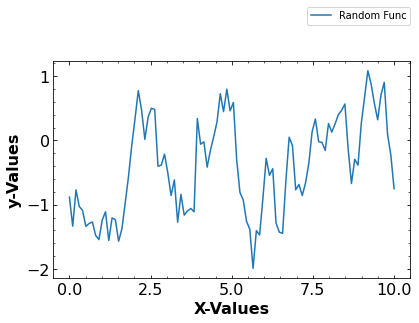

In [2]:
#Set number of experimental data/ set rng
np.random.seed(0) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 1
nsamples = 100
eps = 1e-7
# eps = 0

#Define X data
# Xexp = np.random.rand(nsamples)*10 
Xexp = np.linspace(0,10,nsamples).reshape(-1,ndim)
Yexp = np.sin(Xexp)
# print(Xexp.shape)

#Create a function for euclidean distance between 2 x-vector values
def kernel(x1,x2):
    Vector_diff = x1-x2
    distance = np.exp(-np.linalg.norm(Vector_diff))
    return distance

#Define Covariance Matrix #What is the quick way to do this?
cov = np.zeros((nsamples,nsamples))
#Loop over each sample
for i in range(nsamples):
    #Match with each sample
    for j in range(nsamples):
        x1 = Xexp[i]
        x2 = Xexp[j]
        cov[i,j] = kernel(x1,x2)

#Alternatively,
# def covkernel(xi,xj,l=1.0):
#     dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
#     return np.exp(-1*dij/l)

# cov = covkernel(Xexp,Xexp)

#Add jitter
cov += eps * np.eye(cov.shape[0])

#Set mean function (in this case 0)
mean=np.zeros(nsamples) # zero mean

#Generate multivariate normal distribution
Y = rng.multivariate_normal(mean,cov)

#Plot data
plt.figure(figsize = (6.4,4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
#         plt.gca().axes.xaxis.set_ticklabels([]) # remove tick labels
#         plt.gca().axes.yaxis.set_ticklabels([])

#plot training data, testing data, and true values
plt.plot(Xexp, Y, label="Random Func")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
#         plt.legend(loc = "best")
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

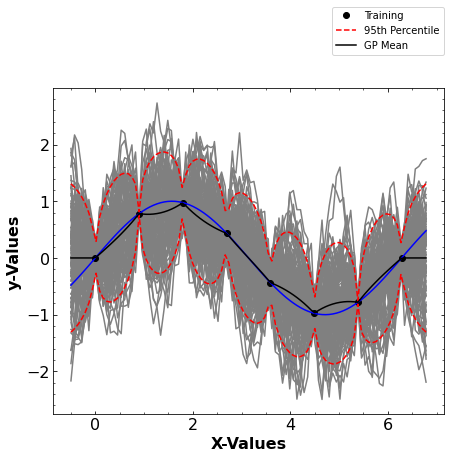

In [3]:
#Set number of experimental data/ set rng
np.random.seed(10) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 1
nsamples = 8
nsamples_test = 100
eps = 1e-14

#Define X data
# Xexp = np.random.rand(nsamples)*10 
X = np.linspace(0,2*np.pi,nsamples)[:,np.newaxis]
Y = np.sin(X)

#Create a kernel function
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-1*dij/l)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
Sigma += eps * np.eye(Sigma.shape[0])

#Define Covariance Matrix for testing data set and add jitter
XX = np.linspace(-0.5,2*np.pi+0.5,nsamples_test)[:,np.newaxis]
SXX = covkernel(XX,XX,l=1.0)
SXX += eps * np.eye(SXX.shape[0])

#Define covariance between testing and training data and add jitter
#Note SX does not have jitter because it is not decomposed and isn't necessarily square
SX = covkernel(XX,X,l=1.0)

#Calculate posterior mean and variance
inv_Sig = np.linalg.inv(Sigma)
mup = SX@inv_Sig@Y
sigmap = SXX - SX@inv_Sig@SX.T

#Generate 100 predictions, YY for XX
YY = rng.multivariate_normal(mup[:,0],sigmap, nsamples_test)

#Calculate 5th and 95th percentiles for calculations
# sample_mean = np.mean(YY,axis=0)
# sample_stdev = np.std(YY, axis =0)
# q1   = sample_mean + 1*sample_stdev
# q2  = sample_mean - 1*sample_stdev
q1 = mup[:,0] + norm.ppf(0.05, loc=0, scale=np.sqrt(np.diag(sigmap)))
q2 = mup[:,0] + norm.ppf(0.95, loc=0, scale=np.sqrt(np.diag(sigmap)))

#Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(XX[:,0], YY.T, color = "grey")
plt.plot(X[:,0], Y[:,0], marker = 'o',color='k', label = "Training", linestyle = "None")
plt.plot(XX[:,0], np.sin(XX), color = "blue")
plt.plot(XX[:,0], q1,  linestyle='dashed', color = "red", label = "95th Percentile")
plt.plot(XX[:,0], q2,  linestyle='dashed', color = "red")
plt.plot(XX[:,0], mup[:,0], color = "black", label = "GP Mean")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

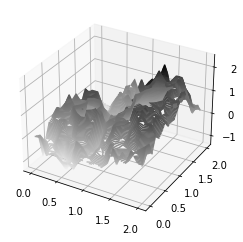

In [4]:
#In higher dimensions
#Set number of experimental data/ set rng
np.random.seed() #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim = 2
nx = 20
eps = 1e-14

#Define 2D X data
x = np.linspace(0,2,nx)
X = np.array(list(itertools.product(x, repeat=ndim)))

#Create a kernel function
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-1*dij/l)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
Sigma += eps * np.eye(Sigma.shape[0])

#Set mean function (in this case 0)
mean=np.zeros(nx**ndim) # zero mean

#Generate multivariate normal distribution
Y = rng.multivariate_normal(mean,Sigma)

fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
ax.contour3D(x, x, Y.reshape(nx,nx), 100, cmap='binary')

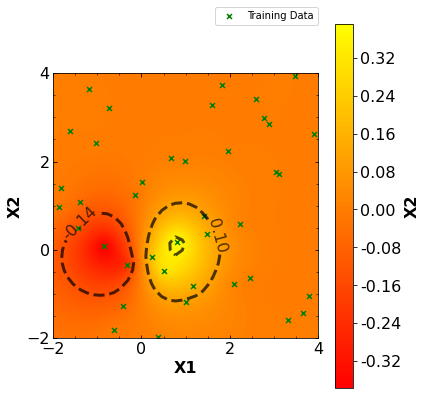

In [5]:
#Set number of experimental data/ set rng
np.random.seed(10) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 2
nsamples = 40
eps = 1e-14

#Generate X data from LHS
X = LHS_Design(nsamples, ndim, seed = 10)
#Modify X data to correct scale
X[:,0] = (X[:,0] - 0.5)*6 +1
X[:,1] = (X[:,1] - 0.5)*6 +1

#Generate y data
y = X[:,0]*np.exp(-X[:,0]**2 -X[:,1]**2)


xx = np.linspace(-2,4,nsamples)
XX_mesh = np.array(np.meshgrid(xx,xx))
XX = XX_mesh.reshape((2,nsamples**2)).T

#Create Covariance Matrix for X
#Create a kernel function
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-1*dij/l)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
Sigma += eps * np.eye(Sigma.shape[0])

#Define Covariance Matrix for testing data set and add jitter
SXX = covkernel(XX,XX,l=1.0)
SXX += eps * np.eye(SXX.shape[0])

#Define covariance between testing and training data and add jitter
#Note SX does not have jitter because it is not decomposed and isn't necessarily square
SX = covkernel(XX,X,l=1.0)

#Calculate posterior mean and variance
inv_Sig = np.linalg.inv(Sigma)
mup = SX@inv_Sig@y
sigmap = SXX - SX@inv_Sig@SX.T
sdp = np.sqrt(np.diag(sigmap))

#Plot
X1, X2 = XX_mesh
Z = mup.reshape(nsamples,nsamples)

#Set plot details
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
cs = plt.contourf(X1, X2,Z, levels = 100, cmap = "autumn")
ax.set_box_aspect(1)
if np.amax(Z) < 1e-1 or np.amax(Z) > 1000:
    cbar = plt.colorbar(cs, format='%.2e')
else:
    cbar = plt.colorbar(cs, format = '%2.2f')
cbar.ax.set_ylabel("X2", fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=16)
levels =30
cs2 = plt.contour(cs, levels=cs.levels[::levels], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)
if np.amax(Z) < 1e-1 or np.amax(Z) > 1000:
    plt.clabel(cs2, fmt='%.2e', colors='k', fontsize=16)
else:
    plt.clabel(cs2, fmt='%2.2f', colors='k', fontsize=16)
plt.scatter(X[:,0],X[:,1], color="green",s=25, label = "Training Data", marker = "x")
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
plt.xlabel("X1",fontsize=16,fontweight='bold')
plt.ylabel("X2",fontsize=16,fontweight='bold')
plt.xlim((np.amin(X1), np.amax(X1)))
plt.ylim((np.amin(X2),np.amax(X2)))   
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
fig.tight_layout()

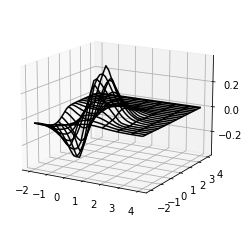

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
ax.plot_wireframe(X1, X2, Z, rstride=2, cstride=5, color = "black")
ax.view_init(15, -60)
plt.show()